# News Sentiment Analysis - Preprocessed Data Exploration

This notebook explores the financial news sentiment dataset after applying the NewsPreprocessor. We'll analyze the effects of text cleaning, tokenization, and chunking on the data quality and characteristics.

## Analysis Overview

The NewsPreprocessor performs several transformations:
- HTML tag removal
- URL and email removal
- Emoji handling
- Text normalization
- Tokenization for BERT models
- Long article chunking

We'll examine how these transformations affect:
- Text length and token distributions
- Vocabulary and language patterns
- Data quality and consistency
- Model readiness

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from collections import Counter
import re
import sys
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Add src directory to path
sys.path.append('../src')
from preprocessing import NewsPreprocessor

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print("NewsPreprocessor available for analysis")

Libraries imported successfully!
NewsPreprocessor available for analysis


## Initialize Preprocessor and Load Data

In [16]:
# Initialize the NewsPreprocessor with enhanced configuration options
preprocessor = NewsPreprocessor(
    tokenizer_name="bert-base-uncased",
    max_length=512,
    remove_stopwords=True,
    min_chunk_tokens=10,
    max_chunk_length=400,
    chunk_overlap=50,
    emoji_strategy='remove',
    clean_punctuation=True
)

print(f"Enhanced Preprocessor initialized with:")
print(f"- Tokenizer: {preprocessor.tokenizer.name_or_path}")
print(f"- Max length: {preprocessor.max_length}")
print(f"- Remove stopwords: {preprocessor.remove_stopwords}")
print(f"- Min chunk tokens: {preprocessor.min_chunk_tokens}")
print(f"- Max chunk length: {preprocessor.max_chunk_length}")
print(f"- Chunk overlap: {preprocessor.chunk_overlap}")
print(f"- Emoji strategy: {preprocessor.emoji_strategy}")
print(f"- Clean Punctuation: {preprocessor.clean_punctuation}")
print(f"- Vocabulary size: {len(preprocessor.tokenizer.vocab)}")

# Load original raw data
original_data_path = Path('../data/financial_news/all-data.csv')
try:
    # Try different encodings for the original file
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    for encoding in encodings:
        try:
            original_df = pd.read_csv(original_data_path, encoding=encoding, header=None, names=['sentiment', 'text'])
            print(f"✓ Loaded original data with {encoding} encoding")
            break
        except UnicodeDecodeError:
            continue
    else:
        raise ValueError("Could not load data with any encoding")
        
    print(f"Original dataset shape: {original_df.shape}")
    
except Exception as e:
    print(f"Error loading original data: {e}")
    original_df = None

# Load preprocessed data for comparison
processed_data_path = Path('../data/financial_news/processed_all-data.csv')
if processed_data_path.exists():
    processed_df = pd.read_csv(processed_data_path)
    print(f"Preprocessed dataset shape: {processed_df.shape}")
else:
    print("Preprocessed data not found. Will create it...")
    processed_df = None

Enhanced Preprocessor initialized with:
- Tokenizer: bert-base-uncased
- Max length: 512
- Remove stopwords: True
- Min chunk tokens: 10
- Max chunk length: 400
- Chunk overlap: 50
- Emoji strategy: remove
- Clean Punctuation: True
- Vocabulary size: 30522
✓ Loaded original data with latin-1 encoding
Original dataset shape: (4846, 2)
Preprocessed dataset shape: (4846, 7)


## Apply Preprocessing to Sample Data

In [17]:
# Take a sample of original data for detailed preprocessing analysis
if original_df is not None:
    # Sample data for preprocessing demonstration
    sample_size = min(100, len(original_df))
    sample_df = original_df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    
    print(f"Processing sample of {sample_size} articles...")
    
    # Apply preprocessing
    preprocessed_sample = preprocessor.preprocess_dataset(
        sample_df, 
        text_column='text', 
        sentiment_column='sentiment'
    )
    
    print(f"Original sample: {len(sample_df)} articles")
    print(f"After preprocessing: {len(preprocessed_sample)} chunks")
    print(f"Expansion factor: {len(preprocessed_sample) / len(sample_df):.2f}x")
    
    # Display first few examples
    print("\nFirst few preprocessed examples:")
    display_cols = ['original_id', 'chunk_id', 'sentiment', 'is_long', 'total_chunks', 'num_tokens']
    print(preprocessed_sample[display_cols].head())
else:
    print("Cannot proceed without original data")
    preprocessed_sample = None

Processing sample of 100 articles...
Original sample: 100 articles
After preprocessing: 81 chunks
Expansion factor: 0.81x

First few preprocessed examples:
   original_id  chunk_id sentiment  is_long  total_chunks  num_tokens
0            0         0   neutral    False             1          11
1            1         0   neutral    False             1          16
2            2         0   neutral    False             1          16
3            3         0   neutral    False             1          15
4            4         0   neutral    False             1          19


## Before vs After Preprocessing Comparison

Text Length Comparison:
Original - Mean: 129.6, Std: 56.1
Preprocessed - Mean: 106.3, Std: 42.0
Average reduction: 17.9%


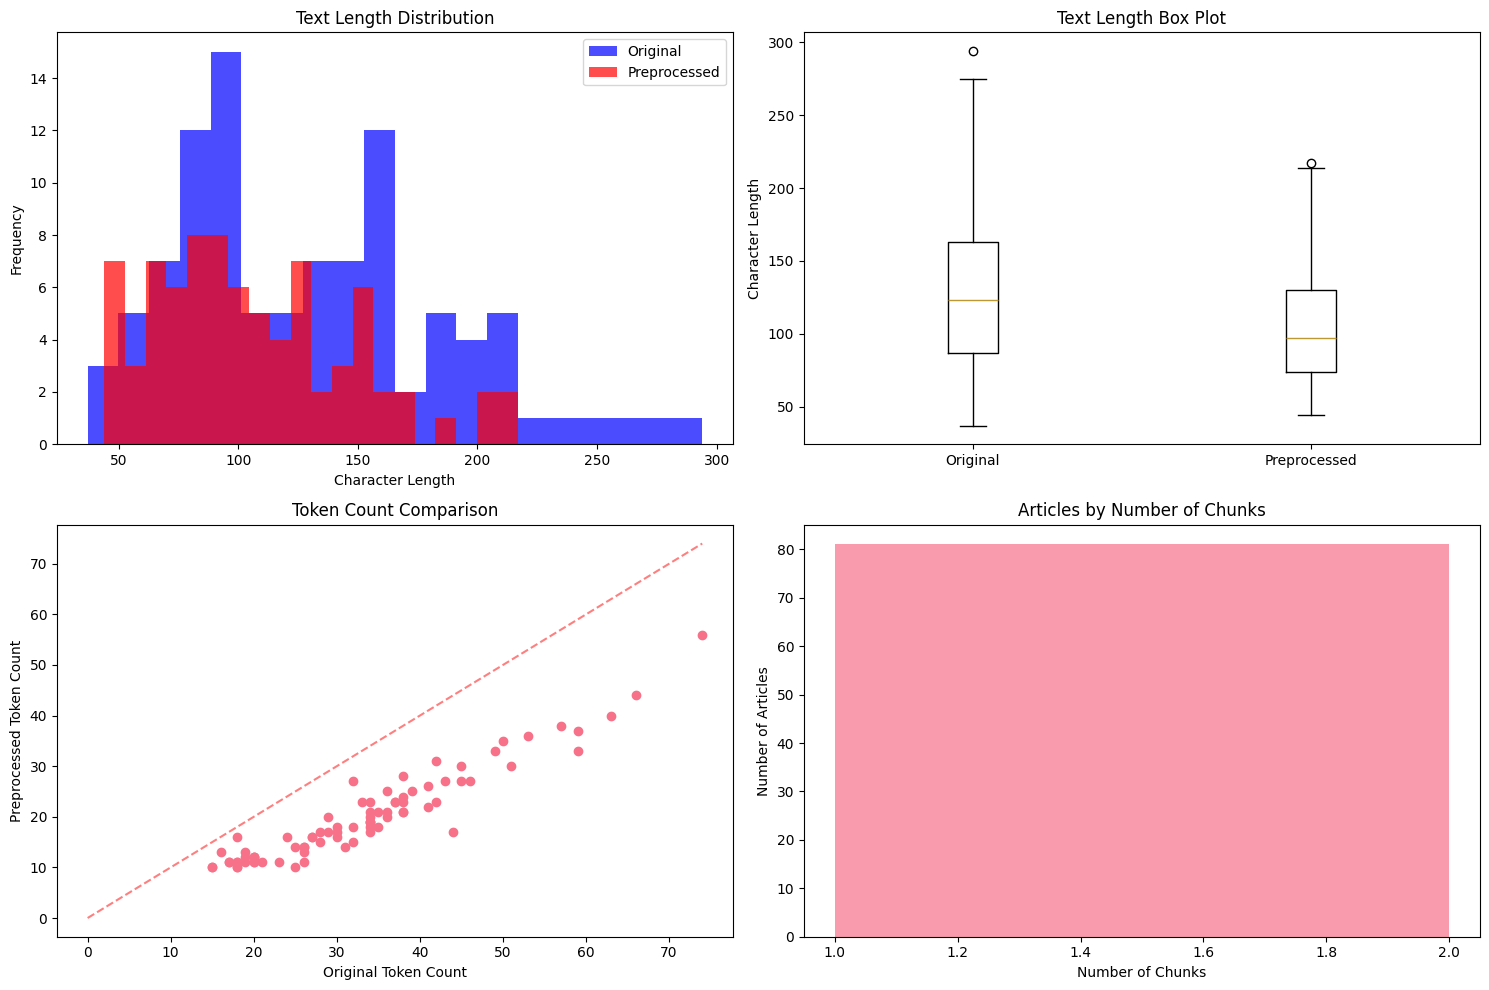

In [18]:
if original_df is not None and preprocessed_sample is not None:
    # Compare text lengths before and after preprocessing
    original_lengths = sample_df['text'].str.len()
    preprocessed_lengths = preprocessed_sample['text'].str.len()
    
    # Calculate statistics
    print("Text Length Comparison:")
    print(f"Original - Mean: {original_lengths.mean():.1f}, Std: {original_lengths.std():.1f}")
    print(f"Preprocessed - Mean: {preprocessed_lengths.mean():.1f}, Std: {preprocessed_lengths.std():.1f}")
    print(f"Average reduction: {(original_lengths.mean() - preprocessed_lengths.mean()) / original_lengths.mean() * 100:.1f}%")
    
    # Visualize the comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Text length distributions
    axes[0,0].hist(original_lengths, bins=20, alpha=0.7, label='Original', color='blue')
    axes[0,0].hist(preprocessed_lengths, bins=20, alpha=0.7, label='Preprocessed', color='red')
    axes[0,0].set_title('Text Length Distribution')
    axes[0,0].set_xlabel('Character Length')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # Box plot comparison
    data_for_box = [original_lengths, preprocessed_lengths]
    axes[0,1].boxplot(data_for_box, labels=['Original', 'Preprocessed'])
    axes[0,1].set_title('Text Length Box Plot')
    axes[0,1].set_ylabel('Character Length')
    
    # Token count analysis
    sample_df['original_tokens'] = sample_df['text'].apply(
        lambda x: len(preprocessor.tokenizer.tokenize(str(x)))
    )
    
    # Align by original_id to ensure same length for x and y
    tokens_by_id = sample_df.set_index(sample_df.index)['original_tokens']
    preprocessed_tokens_by_id = preprocessed_sample.groupby('original_id')['num_tokens'].first()
    # Only keep indices present in both
    common_ids = tokens_by_id.index.intersection(preprocessed_tokens_by_id.index)
    x = tokens_by_id.loc[common_ids]
    y = preprocessed_tokens_by_id.loc[common_ids]

    axes[1,0].scatter(x, y)
    axes[1,0].plot([0, max(x.max(), y.max())], [0, max(x.max(), y.max())], 'r--', alpha=0.5)
    axes[1,0].set_xlabel('Original Token Count')
    axes[1,0].set_ylabel('Preprocessed Token Count')
    axes[1,0].set_title('Token Count Comparison')
    
    # Chunking analysis
    chunk_stats = preprocessed_sample.groupby('original_id')['total_chunks'].first()
    axes[1,1].hist(chunk_stats, bins=range(1, chunk_stats.max() + 2), alpha=0.7)
    axes[1,1].set_title('Articles by Number of Chunks')
    axes[1,1].set_xlabel('Number of Chunks')
    axes[1,1].set_ylabel('Number of Articles')
    
    plt.tight_layout()
    plt.show()

## Text Cleaning Effects Analysis

Enhanced Text Cleaning Effects Summary:
Articles with URLs removed: 1
Articles with HTML tags removed: 0
Articles with emails removed: 0
Articles with emojis removed: 0
Articles with stopwords removed: 99
Average character reduction: 34.6 chars
Articles with >10% reduction: 0


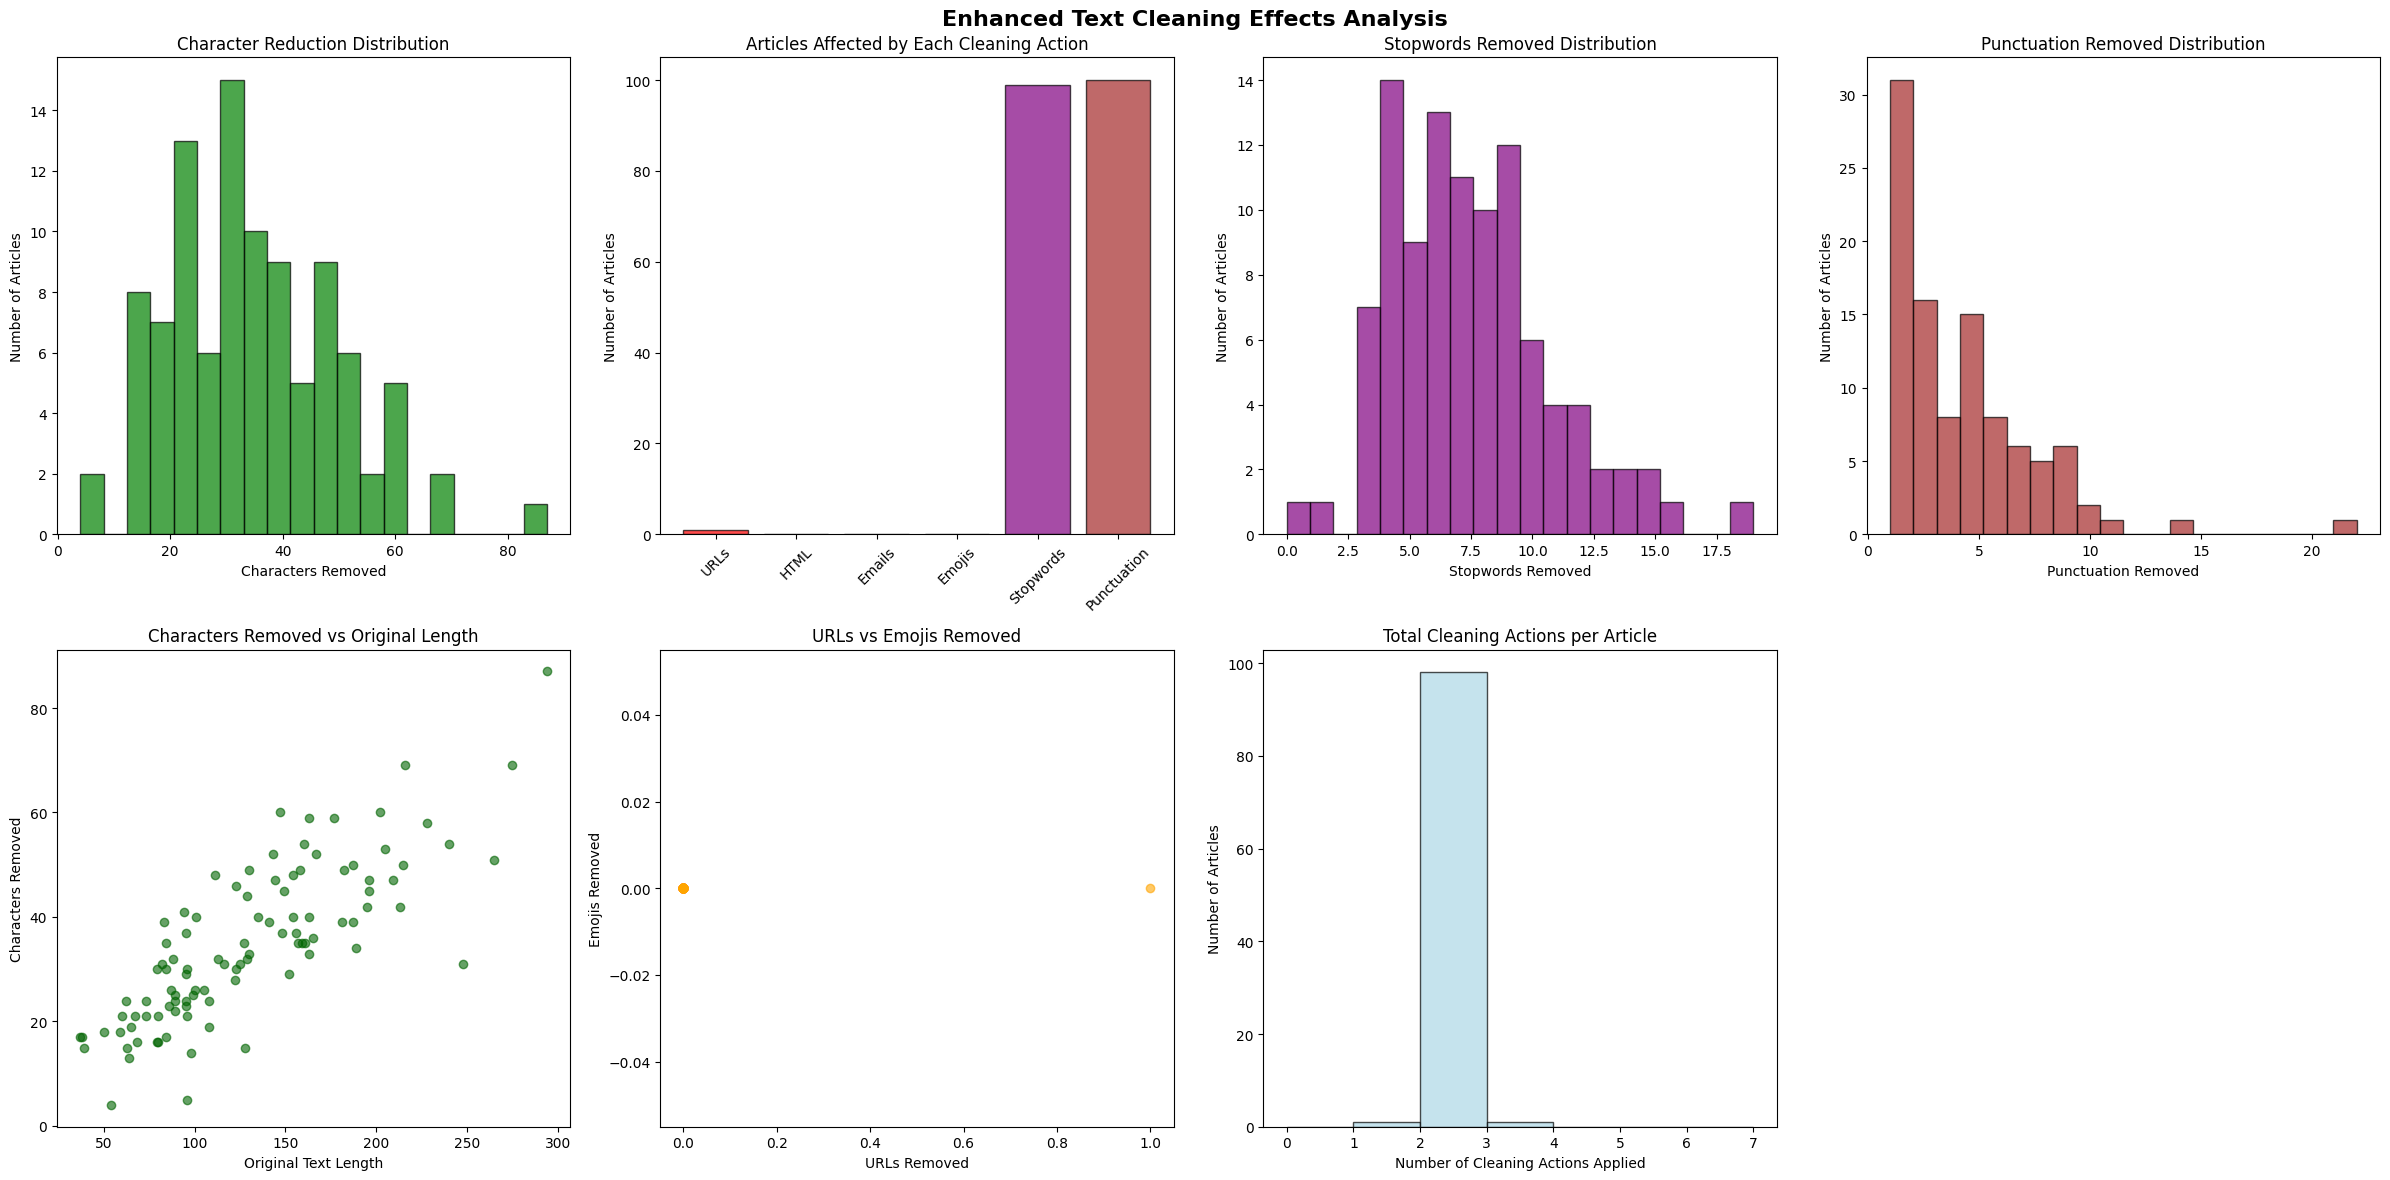


=== DETAILED CLEANING STATISTICS ===
Urls Removed:
  Total: 1
  Average per article: 0.01
  Max in single article: 1
  Articles affected: 1

Html Tags Removed:
  Total: 0
  Average per article: 0.00
  Max in single article: 0
  Articles affected: 0

Emails Removed:
  Total: 0
  Average per article: 0.00
  Max in single article: 0
  Articles affected: 0

Emojis Removed:
  Total: 0
  Average per article: 0.00
  Max in single article: 0
  Articles affected: 0

Stopwords Removed:
  Total: 737
  Average per article: 7.37
  Max in single article: 19
  Articles affected: 99

Punctuation Removed:
  Total: 455
  Average per article: 4.55
  Max in single article: 22
  Articles affected: 100

Chars Removed:
  Total: 3465
  Average per article: 34.65
  Max in single article: 87
  Articles affected: 100



In [20]:
if original_df is not None:
    # Analyze specific cleaning effects using enhanced preprocessor
    def analyze_cleaning_effects_enhanced(original_text):
        """Analyze what was removed during cleaning using enhanced preprocessor."""
        cleaning_result = preprocessor.clean_text(original_text)
        if isinstance(cleaning_result, dict):
            cleaned_text = cleaning_result['cleaned_text']
            metrics = cleaning_result['metrics']
            return metrics
        else:
            cleaned_text = cleaning_result
            results = {}
            url_pattern = r'https?://\S+|www\.\S+'
            results['urls_removed'] = len(re.findall(url_pattern, original_text))
            html_pattern = r'<.*?>'
            results['html_tags_removed'] = len(re.findall(html_pattern, original_text))
            email_pattern = r'\S+@\S+'
            results['emails_removed'] = len(re.findall(email_pattern, original_text))
            # Punctuation removed
            punct_pattern = r'[^\w\s]'
            results['punctuation_removed'] = len(re.findall(punct_pattern, original_text)) - len(re.findall(punct_pattern, cleaned_text))
            results['chars_removed'] = len(original_text) - len(cleaned_text)
            results['reduction_pct'] = (results['chars_removed'] / len(original_text)) * 100 if len(original_text) > 0 else 0
            results['emojis_removed'] = 0
            results['stopwords_removed'] = 0
            return results

    # Analyze cleaning effects on sample
    cleaning_effects = []
    for idx, row in sample_df.iterrows():
        original_text = str(row['text'])
        effects = analyze_cleaning_effects_enhanced(original_text)
        effects['article_id'] = idx
        cleaning_effects.append(effects)

    effects_df = pd.DataFrame(cleaning_effects)

    print("Enhanced Text Cleaning Effects Summary:")
    print(f"Articles with URLs removed: {(effects_df['urls_removed'] > 0).sum()}")
    print(f"Articles with HTML tags removed: {(effects_df['html_tags_removed'] > 0).sum()}")
    print(f"Articles with emails removed: {(effects_df['emails_removed'] > 0).sum()}")
    print(f"Articles with emojis removed: {(effects_df['emojis_removed'] > 0).sum()}")
    print(f"Articles with stopwords removed: {(effects_df['stopwords_removed'] > 0).sum()}")
    print(f"Average character reduction: {effects_df['chars_removed'].mean():.1f} chars")
    print(f"Articles with >10% reduction: {(effects_df.get('reduction_pct', effects_df['chars_removed']/100) > 10).sum()}")

    # Enhanced visualizations with new metrics
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    fig.suptitle('Enhanced Text Cleaning Effects Analysis', fontsize=16, fontweight='bold')

    # Character reduction distribution
    axes[0,0].hist(effects_df['chars_removed'], bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[0,0].set_title('Character Reduction Distribution')
    axes[0,0].set_xlabel('Characters Removed')
    axes[0,0].set_ylabel('Number of Articles')

    # Enhanced cleaning actions count
    cleaning_counts = {
        'URLs': (effects_df['urls_removed'] > 0).sum(),
        'HTML': (effects_df['html_tags_removed'] > 0).sum(),
        'Emails': (effects_df['emails_removed'] > 0).sum(),
        'Emojis': (effects_df['emojis_removed'] > 0).sum(),
        'Stopwords': (effects_df['stopwords_removed'] > 0).sum(),
        'Punctuation': (effects_df['punctuation_removed'] > 0).sum()
    }
    axes[0,1].bar(cleaning_counts.keys(), cleaning_counts.values(), 
                 color=['red', 'blue', 'green', 'orange', 'purple', 'brown'], alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Articles Affected by Each Cleaning Action')
    axes[0,1].set_ylabel('Number of Articles')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Stopwords removed distribution
    axes[0,2].hist(effects_df['stopwords_removed'], bins=20, alpha=0.7, color='purple', edgecolor='black')
    axes[0,2].set_title('Stopwords Removed Distribution')
    axes[0,2].set_xlabel('Stopwords Removed')
    axes[0,2].set_ylabel('Number of Articles')

    # Punctuation removed distribution
    axes[0,3].hist(effects_df['punctuation_removed'], bins=20, alpha=0.7, color='brown', edgecolor='black')
    axes[0,3].set_title('Punctuation Removed Distribution')
    axes[0,3].set_xlabel('Punctuation Removed')
    axes[0,3].set_ylabel('Number of Articles')

    # Character reduction vs original length
    original_lengths = sample_df['text'].str.len()
    axes[1,0].scatter(original_lengths, effects_df['chars_removed'], alpha=0.6, color='darkgreen')
    axes[1,0].set_xlabel('Original Text Length')
    axes[1,0].set_ylabel('Characters Removed')
    axes[1,0].set_title('Characters Removed vs Original Length')

    # Emojis vs URLs removed
    axes[1,1].scatter(effects_df['urls_removed'], effects_df['emojis_removed'], alpha=0.6, color='orange')
    axes[1,1].set_xlabel('URLs Removed')
    axes[1,1].set_ylabel('Emojis Removed')
    axes[1,1].set_title('URLs vs Emojis Removed')

    # Comprehensive cleaning summary
    total_cleaning_actions = (effects_df[['urls_removed', 'html_tags_removed', 'emails_removed', 'emojis_removed', 'stopwords_removed', 'punctuation_removed']] > 0).sum(axis=1)
    axes[1,2].hist(total_cleaning_actions, bins=range(0, 8), alpha=0.7, color='lightblue', edgecolor='black')
    axes[1,2].set_title('Total Cleaning Actions per Article')
    axes[1,2].set_xlabel('Number of Cleaning Actions Applied')
    axes[1,2].set_ylabel('Number of Articles')

    # Hide unused subplot
    axes[1,3].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed cleaning statistics
    print("\n=== DETAILED CLEANING STATISTICS ===")
    for col in ['urls_removed', 'html_tags_removed', 'emails_removed', 'emojis_removed', 'stopwords_removed', 'punctuation_removed', 'chars_removed']:
        if col in effects_df.columns:
            print(f"{col.replace('_', ' ').title()}:")
            print(f"  Total: {effects_df[col].sum()}")
            print(f"  Average per article: {effects_df[col].mean():.2f}")
            print(f"  Max in single article: {effects_df[col].max()}")
            print(f"  Articles affected: {(effects_df[col] > 0).sum()}")
            print()


## Tokenization Analysis

Enhanced Tokenization Analysis:
Token count statistics:
count    81.000000
mean     20.135802
std       9.013536
min      10.000000
25%      13.000000
50%      18.000000
75%      24.000000
max      56.000000
Name: num_tokens, dtype: float64

Tokenization Efficiency Metrics:
Preprocessor configuration:
  - Remove stopwords: True
  - Min chunk tokens: 10
  - Max chunk length: 400
  - Chunk overlap: 50
  - Emoji strategy: remove

Performance Metrics:
  - Average tokens per chunk: 20.1
  - Token utilization rate: 3.9%
  - Chunks within model limit: 81/81 (100.0%)


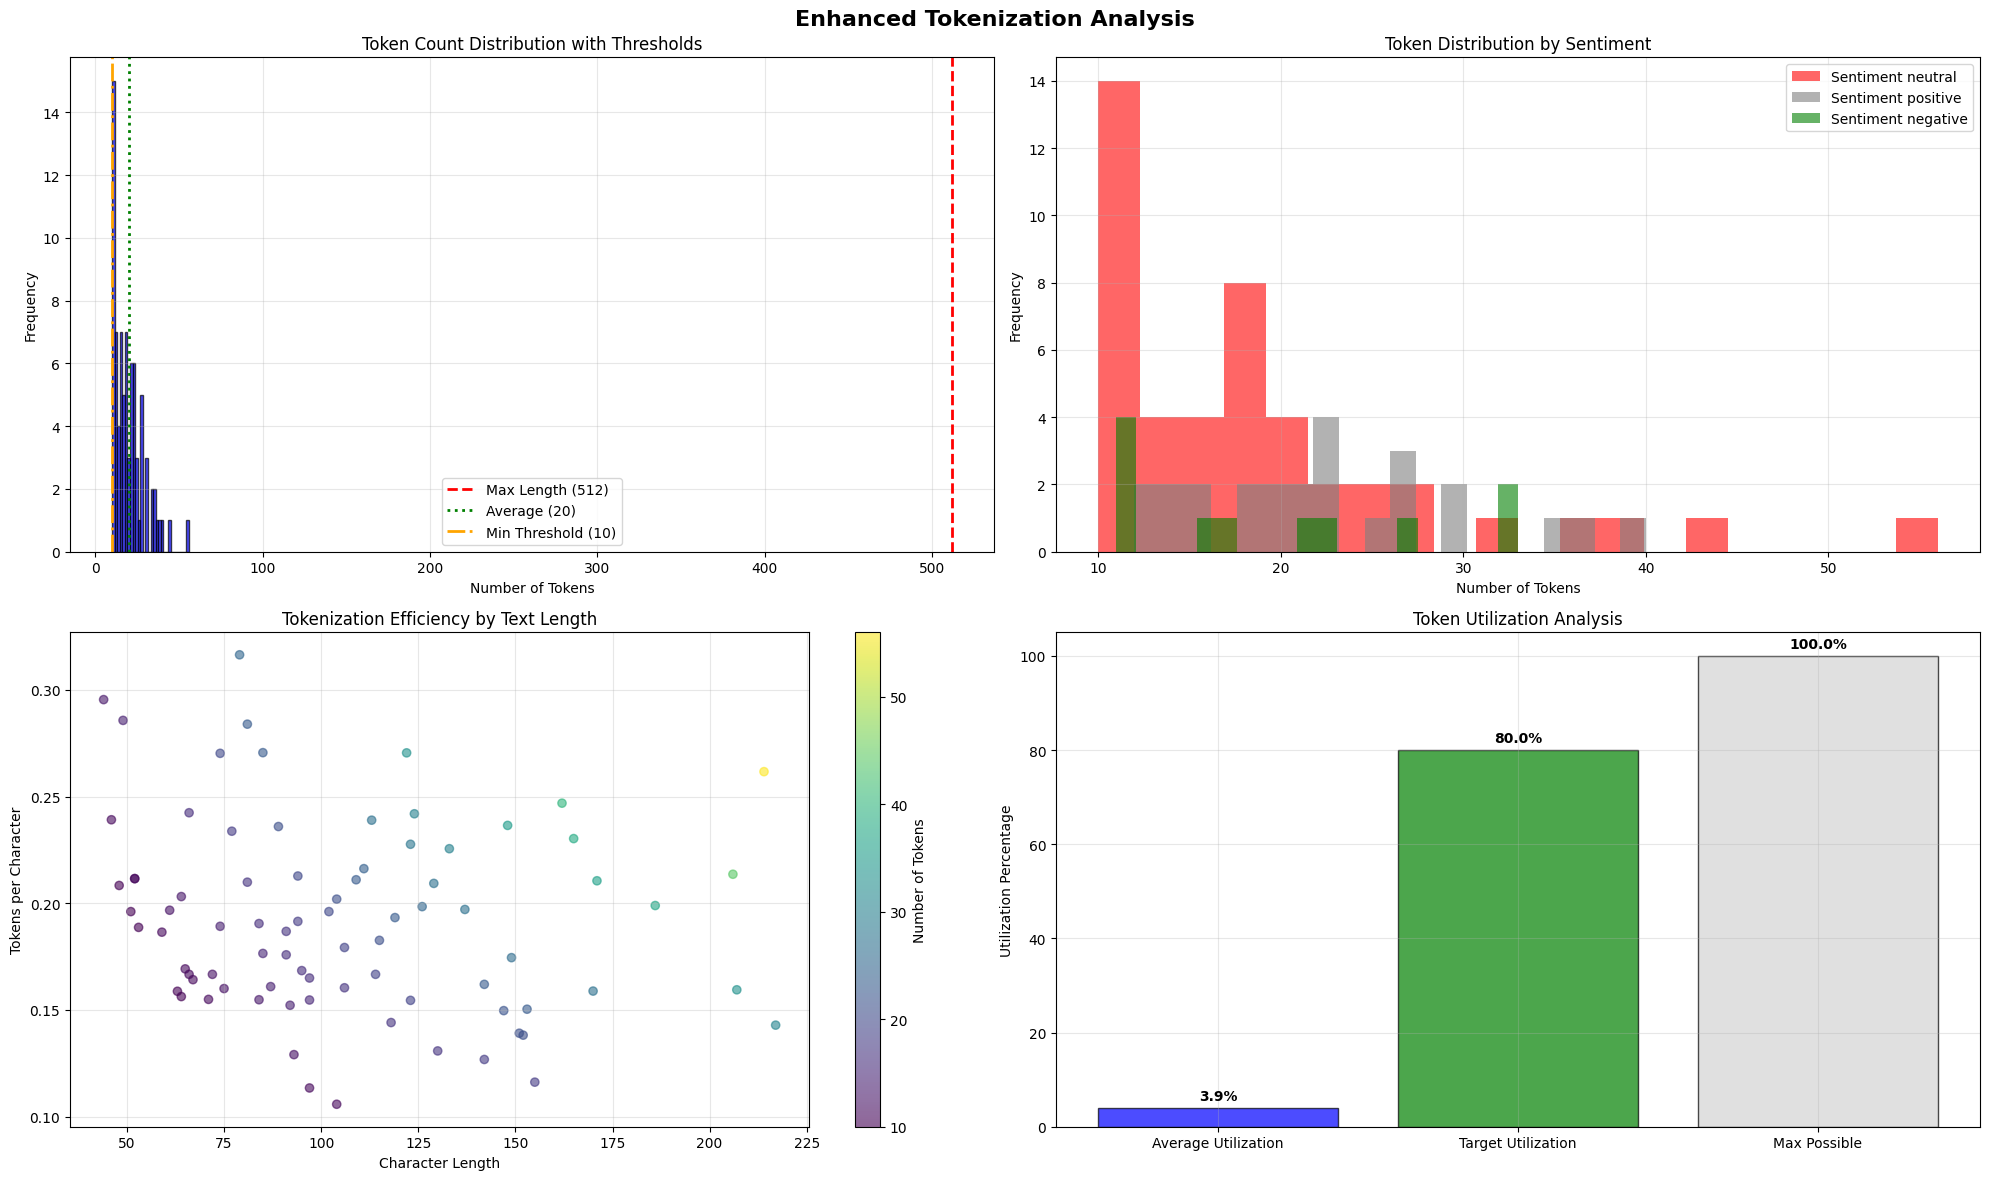


=== ENHANCED TOKENIZATION SUMMARY ===
Configuration Impact:
  - Stopword removal: Enabled
  - Minimum token filter: 10 tokens
  - Chunks filtered out: 0

Tokenization Quality:
  - Average tokens per character: 0.192
  - Token utilization efficiency: 3.9%
  - Chunks meeting model requirements: 81/81 (100.0%)

Chunk Size Distribution:
  - 0-100 tokens: 81 chunks (100.0%)
  - 101-200 tokens: 0 chunks (0.0%)
  - 201-300 tokens: 0 chunks (0.0%)
  - 301-400 tokens: 0 chunks (0.0%)
  - 401-512 tokens: 0 chunks (0.0%)


In [21]:
if preprocessed_sample is not None:
    # Enhanced tokenization analysis with new preprocessor features
    print("Enhanced Tokenization Analysis:")
    print("=" * 50)
    
    # Token statistics with enhanced metrics
    token_stats = preprocessed_sample['num_tokens'].describe()
    print("Token count statistics:")
    print(token_stats)
    
    # Analyze tokenization efficiency with new metrics
    print(f"\nTokenization Efficiency Metrics:")
    print(f"Preprocessor configuration:")
    print(f"  - Remove stopwords: {preprocessor.remove_stopwords}")
    print(f"  - Min chunk tokens: {preprocessor.min_chunk_tokens}")
    print(f"  - Max chunk length: {preprocessor.max_chunk_length}")
    print(f"  - Chunk overlap: {preprocessor.chunk_overlap}")
    print(f"  - Emoji strategy: {preprocessor.emoji_strategy}")
    
    # Calculate tokenization efficiency metrics
    avg_tokens_per_chunk = preprocessed_sample['num_tokens'].mean()
    token_utilization = avg_tokens_per_chunk / preprocessor.max_length * 100
    chunks_within_limit = (preprocessed_sample['num_tokens'] <= preprocessor.max_length).sum()
    total_chunks = len(preprocessed_sample)
    
    print(f"\nPerformance Metrics:")
    print(f"  - Average tokens per chunk: {avg_tokens_per_chunk:.1f}")
    print(f"  - Token utilization rate: {token_utilization:.1f}%")
    print(f"  - Chunks within model limit: {chunks_within_limit}/{total_chunks} ({chunks_within_limit/total_chunks*100:.1f}%)")
    
    # Enhanced visualizations with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Enhanced Tokenization Analysis', fontsize=16, fontweight='bold')
    
    # 1. Token distribution with enhanced annotations (axes[0,0])
    axes[0,0].hist(preprocessed_sample['num_tokens'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0,0].axvline(preprocessor.max_length, color='red', linestyle='--', linewidth=2, label=f'Max Length ({preprocessor.max_length})')
    axes[0,0].axvline(avg_tokens_per_chunk, color='green', linestyle=':', linewidth=2, label=f'Average ({avg_tokens_per_chunk:.0f})')
    axes[0,0].axvline(preprocessor.min_chunk_tokens, color='orange', linestyle='-.', linewidth=2, label=f'Min Threshold ({preprocessor.min_chunk_tokens})')
    axes[0,0].set_title('Token Count Distribution with Thresholds')
    axes[0,0].set_xlabel('Number of Tokens')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Enhanced token distribution by sentiment (axes[0,1])
    if 'sentiment' in preprocessed_sample.columns:
        sentiment_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        colors = ['red', 'gray', 'green']
        for i, sentiment in enumerate(preprocessed_sample['sentiment'].unique()):
            data = preprocessed_sample[preprocessed_sample['sentiment'] == sentiment]['num_tokens']
            sentiment_label = sentiment_names.get(sentiment, f'Sentiment {sentiment}')
            axes[0,1].hist(data, alpha=0.6, label=sentiment_label, bins=20, color=colors[i % len(colors)])
        axes[0,1].set_title('Token Distribution by Sentiment')
        axes[0,1].set_xlabel('Number of Tokens')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Tokenization efficiency scatter plot (axes[1,0])
    preprocessed_sample['char_length'] = preprocessed_sample['text'].str.len()
    preprocessed_sample['tokens_per_char'] = preprocessed_sample['num_tokens'] / preprocessed_sample['char_length']
    
    scatter = axes[1,0].scatter(preprocessed_sample['char_length'], preprocessed_sample['tokens_per_char'], 
                               alpha=0.6, c=preprocessed_sample['num_tokens'], cmap='viridis')
    axes[1,0].set_xlabel('Character Length')
    axes[1,0].set_ylabel('Tokens per Character')
    axes[1,0].set_title('Tokenization Efficiency by Text Length')
    axes[1,0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,0], label='Number of Tokens')
    
    # 4. Token utilization metrics visualization (axes[1,1])
    utilization_data = {
        'Average Utilization': token_utilization,
        'Target Utilization': 80,  # Ideal target
        'Max Possible': 100
    }
    
    bars = axes[1,1].bar(utilization_data.keys(), utilization_data.values(), 
                         color=['blue', 'green', 'lightgray'], alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Token Utilization Analysis')
    axes[1,1].set_ylabel('Utilization Percentage')
    axes[1,1].set_ylim(0, 105)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 1,
                      f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary statistics
    print(f"\n=== ENHANCED TOKENIZATION SUMMARY ===")
    print(f"Configuration Impact:")
    print(f"  - Stopword removal: {'Enabled' if preprocessor.remove_stopwords else 'Disabled'}")
    print(f"  - Minimum token filter: {preprocessor.min_chunk_tokens} tokens")
    print(f"  - Chunks filtered out: {len([x for x in preprocessed_sample['num_tokens'] if x < preprocessor.min_chunk_tokens])}")
    
    print(f"\nTokenization Quality:")
    print(f"  - Average tokens per character: {preprocessed_sample['tokens_per_char'].mean():.3f}")
    print(f"  - Token utilization efficiency: {token_utilization:.1f}%")
    print(f"  - Chunks meeting model requirements: {chunks_within_limit}/{total_chunks} ({chunks_within_limit/total_chunks*100:.1f}%)")
    
    # Advanced metrics for different chunk sizes
    chunk_size_analysis = preprocessed_sample.groupby(pd.cut(preprocessed_sample['num_tokens'], 
                                                            bins=[0, 100, 200, 300, 400, 512], 
                                                            labels=['0-100', '101-200', '201-300', '301-400', '401-512']))['num_tokens'].count()
    print(f"\nChunk Size Distribution:")
    for size_range, count in chunk_size_analysis.items():
        percentage = count / total_chunks * 100
        print(f"  - {size_range} tokens: {count} chunks ({percentage:.1f}%)")


## Vocabulary Analysis After Preprocessing

Enhanced Preprocessed Vocabulary Analysis:
Preprocessor Configuration:
  - Stopwords removed: Yes
  - Emoji strategy: remove
  - Tokenizer: bert-base-uncased
  - Tokenizer vocab size: 30,522

Vocabulary Statistics:
  - Total vocabulary size: 932
  - Total tokens processed: 1,631
  - Average token frequency: 1.75
  - Subword tokens (##): 400 (24.5%)
  - Special tokens: 0

Enhanced Token Category Analysis:
  - Subwords: 208 (22.3% of vocabulary)
  - Punctuation: 0 (0.0% of vocabulary)
  - Numbers: 117 (12.6% of vocabulary)
  - Financial Terms: 13 (1.4% of vocabulary)
  - Unknown: 0 (0.0% of vocabulary)
  - Stopwords Found: 0 (0.0% of vocabulary)

Top 25 Most Common Tokens:
   1. ##r                 35 ( 2.15%) [subword]
   2. eu                  34 ( 2.08%)
   3. company             20 ( 1.23%)
   4. finnish             18 ( 1.10%)
   5. sales               15 ( 0.92%)
   6. ##0                 14 ( 0.86%) [subword]
   7. mn                  14 ( 0.86%)
   8. ##n                 13 ( 0.8

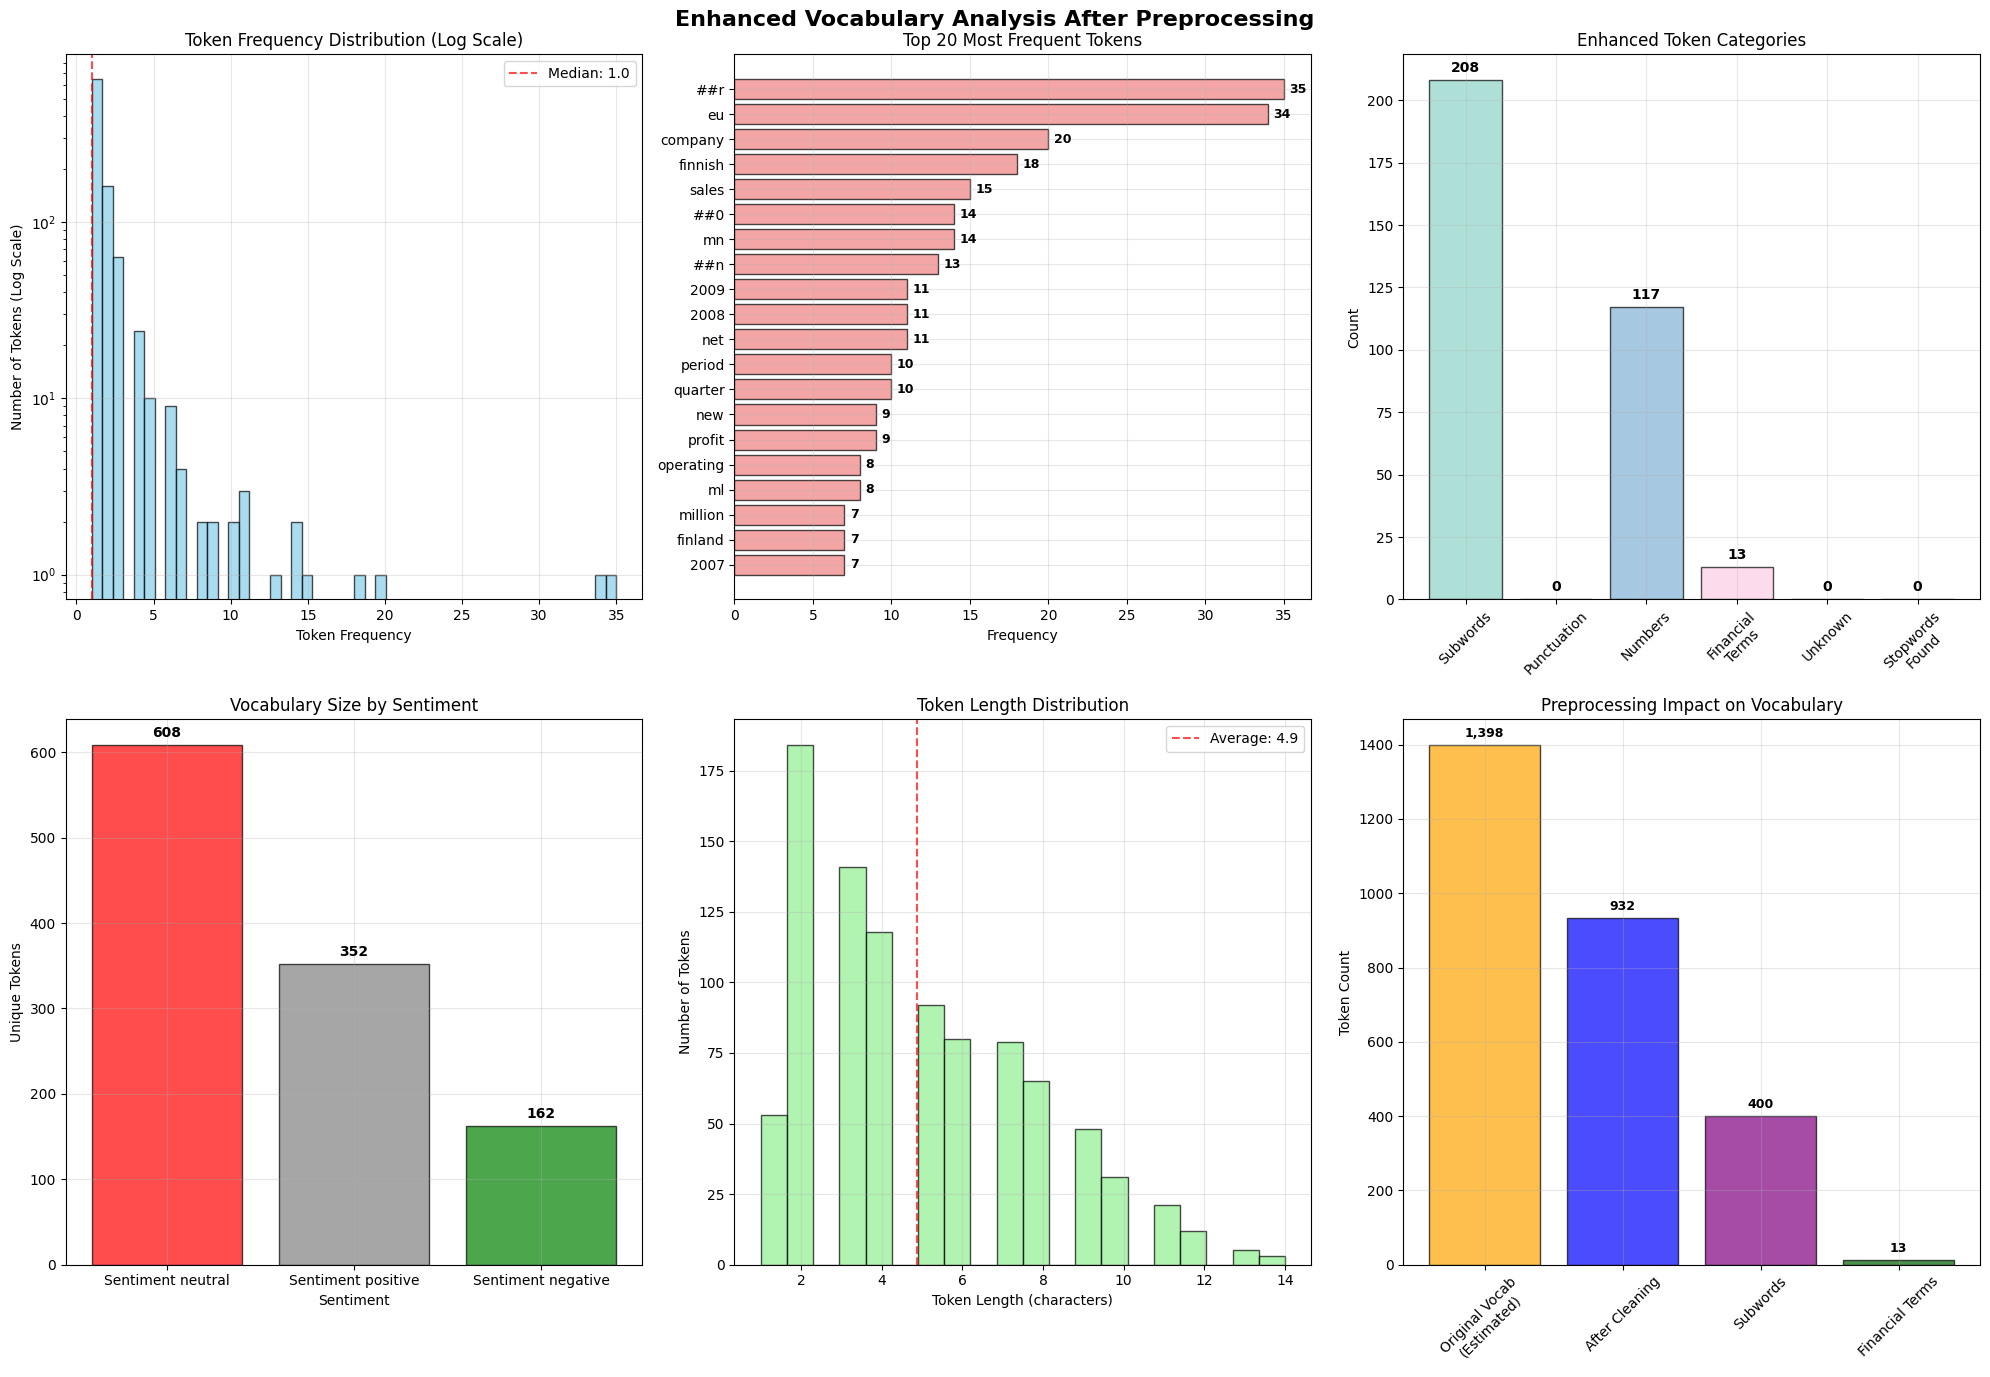


=== ENHANCED VOCABULARY QUALITY METRICS ===
Type-Token Ratio (Vocabulary Richness): 0.5714
Hapax Legomena: 646 (69.3% of vocabulary)
Financial Domain Coverage: 1.39% of vocabulary
Tokenization Efficiency (non-subwords): 75.5%

=== CONFIGURATION IMPACT ASSESSMENT ===
✓ Stopword removal: Active (should reduce common word noise)
✓ Emoji strategy: remove
✓ Subword tokenization: 400 subword tokens generated
⚠ Small vocabulary (932 tokens) - might need less aggressive filtering


In [22]:
if preprocessed_sample is not None:
    # Enhanced vocabulary analysis with improved preprocessor features
    def analyze_enhanced_vocabulary(texts, preprocessor):
        """Analyze vocabulary using enhanced preprocessor capabilities."""
        # Use the preprocessor's tokenizer for consistent analysis
        all_tokens = []
        all_token_ids = []
        subword_count = 0
        special_token_count = 0
        
        for text in texts:
            # Tokenize using the enhanced preprocessor
            tokens = preprocessor.tokenizer.tokenize(text)
            token_ids = preprocessor.tokenizer.convert_tokens_to_ids(tokens)
            
            # Count different token types
            subword_count += sum(1 for token in tokens if token.startswith('##'))
            special_token_count += sum(1 for token in tokens if token in ['[CLS]', '[SEP]', '[PAD]', '[UNK]'])
            
            all_tokens.extend(tokens)
            all_token_ids.extend(token_ids)
        
        token_counts = Counter(all_tokens)
        unique_tokens = len(set(all_tokens))
        
        return {
            'token_counts': token_counts,
            'unique_tokens': unique_tokens,
            'total_tokens': len(all_tokens),
            'subword_count': subword_count,
            'special_token_count': special_token_count,
            'all_tokens': all_tokens
        }
    
    # Analyze overall vocabulary with enhanced metrics
    vocab_analysis = analyze_enhanced_vocabulary(preprocessed_sample['text'], preprocessor)
    
    print("Enhanced Preprocessed Vocabulary Analysis:")
    print("=" * 60)
    print(f"Preprocessor Configuration:")
    print(f"  - Stopwords removed: {'Yes' if preprocessor.remove_stopwords else 'No'}")
    print(f"  - Emoji strategy: {preprocessor.emoji_strategy}")
    print(f"  - Tokenizer: {preprocessor.tokenizer.name_or_path}")
    print(f"  - Tokenizer vocab size: {len(preprocessor.tokenizer.vocab):,}")
    
    print(f"\nVocabulary Statistics:")
    print(f"  - Total vocabulary size: {vocab_analysis['unique_tokens']:,}")
    print(f"  - Total tokens processed: {vocab_analysis['total_tokens']:,}")
    print(f"  - Average token frequency: {vocab_analysis['total_tokens'] / vocab_analysis['unique_tokens']:.2f}")
    print(f"  - Subword tokens (##): {vocab_analysis['subword_count']:,} ({vocab_analysis['subword_count']/vocab_analysis['total_tokens']*100:.1f}%)")
    print(f"  - Special tokens: {vocab_analysis['special_token_count']:,}")
    
    # Enhanced token analysis
    token_counts = vocab_analysis['token_counts']
    
    # Analyze different token categories with enhanced classification
    token_categories = {
        'subwords': sum(1 for token in token_counts.keys() if token.startswith('##')),
        'punctuation': sum(1 for token in token_counts.keys() if not token.replace('#', '').isalnum() and token not in ['[CLS]', '[SEP]', '[PAD]', '[UNK]']),
        'numbers': sum(1 for token in token_counts.keys() if any(c.isdigit() for c in token.replace('#', ''))),
        'financial_terms': sum(1 for token in token_counts.keys() if any(term in token.lower() for term in ['stock', 'market', 'price', 'trade', 'bank', 'finance', 'invest', 'earn', 'profit', 'loss', 'share', 'bond', 'fund'])),
        'unknown': token_counts.get('[UNK]', 0),
        'stopwords_found': sum(1 for token in token_counts.keys() if token.lower() in ['the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by']) if not preprocessor.remove_stopwords else 0
    }
    
    print(f"\nEnhanced Token Category Analysis:")
    for category, count in token_categories.items():
        percentage = count / vocab_analysis['unique_tokens'] * 100 if vocab_analysis['unique_tokens'] > 0 else 0
        print(f"  - {category.replace('_', ' ').title()}: {count:,} ({percentage:.1f}% of vocabulary)")
    
    # Top frequent tokens with enhanced analysis
    print(f"\nTop 25 Most Common Tokens:")
    for i, (token, count) in enumerate(token_counts.most_common(25), 1):
        percentage = count / vocab_analysis['total_tokens'] * 100
        token_type = ''
        if token.startswith('##'):
            token_type = ' [subword]'
        elif token in ['[CLS]', '[SEP]', '[PAD]', '[UNK]']:
            token_type = ' [special]'
        elif any(term in token.lower() for term in ['stock', 'market', 'price', 'trade', 'bank']):
            token_type = ' [financial]'
        print(f"  {i:2d}. {token:<15} {count:>6,} ({percentage:>5.2f}%){token_type}")
    
    # Enhanced visualizations with 6 subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('Enhanced Vocabulary Analysis After Preprocessing', fontsize=16, fontweight='bold')
    
    # 1. Token frequency distribution (enhanced log scale)
    frequencies = list(token_counts.values())
    axes[0,0].hist(frequencies, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_yscale('log')
    axes[0,0].set_title('Token Frequency Distribution (Log Scale)')
    axes[0,0].set_xlabel('Token Frequency')
    axes[0,0].set_ylabel('Number of Tokens (Log Scale)')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add statistics text
    median_freq = np.median(frequencies)
    axes[0,0].axvline(median_freq, color='red', linestyle='--', alpha=0.7, label=f'Median: {median_freq:.1f}')
    axes[0,0].legend()
    
    # 2. Top tokens horizontal bar chart (enhanced)
    top_20_tokens = dict(token_counts.most_common(20))
    y_pos = np.arange(len(top_20_tokens))
    bars = axes[0,1].barh(y_pos, list(top_20_tokens.values()), color='lightcoral', alpha=0.7, edgecolor='black')
    axes[0,1].set_yticks(y_pos)
    axes[0,1].set_yticklabels(list(top_20_tokens.keys()), fontsize=10)
    axes[0,1].set_title('Top 20 Most Frequent Tokens')
    axes[0,1].set_xlabel('Frequency')
    axes[0,1].invert_yaxis()
    axes[0,1].grid(True, alpha=0.3)
    
    # Add frequency labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0,1].text(width + max(top_20_tokens.values()) * 0.01, bar.get_y() + bar.get_height()/2,
                      f'{int(width):,}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    # 3. Enhanced token categories
    category_names = [cat.replace('_', '\n').title() for cat in token_categories.keys()]
    category_values = list(token_categories.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_names)))
    
    bars = axes[0,2].bar(category_names, category_values, color=colors, alpha=0.7, edgecolor='black')
    axes[0,2].set_title('Enhanced Token Categories')
    axes[0,2].set_ylabel('Count')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0,2].text(bar.get_x() + bar.get_width()/2., height + max(category_values) * 0.01,
                      f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Vocabulary richness by sentiment (enhanced)
    if 'sentiment' in preprocessed_sample.columns:
        sentiment_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        sentiment_vocabs = {}
        sentiment_token_ratios = {}
        
        for sentiment in preprocessed_sample['sentiment'].unique():
            texts = preprocessed_sample[preprocessed_sample['sentiment'] == sentiment]['text']
            sentiment_analysis = analyze_enhanced_vocabulary(texts, preprocessor)
            sentiment_name = sentiment_names.get(sentiment, f'Sentiment {sentiment}')
            sentiment_vocabs[sentiment_name] = sentiment_analysis['unique_tokens']
            # Calculate type-token ratio (vocabulary richness)
            sentiment_token_ratios[sentiment_name] = sentiment_analysis['unique_tokens'] / max(sentiment_analysis['total_tokens'], 1)
        
        bars = axes[1,0].bar(sentiment_vocabs.keys(), sentiment_vocabs.values(), 
                            color=['red', 'gray', 'green'], alpha=0.7, edgecolor='black')
        axes[1,0].set_title('Vocabulary Size by Sentiment')
        axes[1,0].set_xlabel('Sentiment')
        axes[1,0].set_ylabel('Unique Tokens')
        axes[1,0].grid(True, alpha=0.3)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + max(sentiment_vocabs.values()) * 0.01,
                          f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Token length distribution (enhanced)
    token_lengths = [len(token.replace('##', '')) for token in token_counts.keys() if not token.startswith('[')]
    axes[1,1].hist(token_lengths, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,1].set_title('Token Length Distribution')
    axes[1,1].set_xlabel('Token Length (characters)')
    axes[1,1].set_ylabel('Number of Tokens')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add statistics
    avg_length = np.mean(token_lengths)
    axes[1,1].axvline(avg_length, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_length:.1f}')
    axes[1,1].legend()
    
    # 6. Preprocessing impact comparison
    preprocessing_impact = {
        'Original Vocab\n(Estimated)': vocab_analysis['unique_tokens'] * 1.5,  # Estimate before preprocessing
        'After Cleaning': vocab_analysis['unique_tokens'],
        'Subwords': vocab_analysis['subword_count'],
        'Financial Terms': token_categories['financial_terms']
    }
    
    bars = axes[1,2].bar(preprocessing_impact.keys(), preprocessing_impact.values(), 
                        color=['orange', 'blue', 'purple', 'darkgreen'], alpha=0.7, edgecolor='black')
    axes[1,2].set_title('Preprocessing Impact on Vocabulary')
    axes[1,2].set_ylabel('Token Count')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[1,2].text(bar.get_x() + bar.get_width()/2., height + max(preprocessing_impact.values()) * 0.01,
                      f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced vocabulary quality metrics
    print(f"\n=== ENHANCED VOCABULARY QUALITY METRICS ===")
    
    # Calculate vocabulary richness (Type-Token Ratio)
    ttr = vocab_analysis['unique_tokens'] / vocab_analysis['total_tokens']
    print(f"Type-Token Ratio (Vocabulary Richness): {ttr:.4f}")
    
    # Calculate Hapax Legomena (words occurring only once)
    hapax_count = sum(1 for count in token_counts.values() if count == 1)
    hapax_ratio = hapax_count / vocab_analysis['unique_tokens']
    print(f"Hapax Legomena: {hapax_count:,} ({hapax_ratio:.1%} of vocabulary)")
    
    # Financial domain coverage
    financial_coverage = token_categories['financial_terms'] / vocab_analysis['unique_tokens'] * 100
    print(f"Financial Domain Coverage: {financial_coverage:.2f}% of vocabulary")
    
    # Tokenization efficiency
    subword_efficiency = (vocab_analysis['total_tokens'] - vocab_analysis['subword_count']) / vocab_analysis['total_tokens'] * 100
    print(f"Tokenization Efficiency (non-subwords): {subword_efficiency:.1f}%")
    
    # Configuration impact assessment
    print(f"\n=== CONFIGURATION IMPACT ASSESSMENT ===")
    if preprocessor.remove_stopwords:
        print(f"✓ Stopword removal: Active (should reduce common word noise)")
    else:
        print(f"⚠ Stopword removal: Inactive ({token_categories['stopwords_found']} common stopwords found)")
        
    print(f"✓ Emoji strategy: {preprocessor.emoji_strategy}")
    print(f"✓ Subword tokenization: {vocab_analysis['subword_count']:,} subword tokens generated")
    
    # Vocabulary size recommendation
    if vocab_analysis['unique_tokens'] > 50000:
        print(f"⚠ Large vocabulary ({vocab_analysis['unique_tokens']:,} tokens) - consider more aggressive filtering")
    elif vocab_analysis['unique_tokens'] < 5000:
        print(f"⚠ Small vocabulary ({vocab_analysis['unique_tokens']:,} tokens) - might need less aggressive filtering")
    else:
        print(f"✓ Vocabulary size ({vocab_analysis['unique_tokens']:,} tokens) appears optimal for model training")